In [1]:
import stackstac
import pystac_client
import pyproj
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo
import numpy as np
import matplotlib.pyplot as plt

catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [3]:
aoi = dict(type="Point", coordinates=[24.784878, -16.664232])
daterange="2022-07-01/2022-08-01"
cloud_cover=20
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "landsat-c2-l2"]},
    {"op": "in", "args": [{"property": "platform"}, [
        # "landsat-5", 
        # "landsat-7", 
        # "landsat-8", 
        "landsat-9"
    ]]},
    {"op": "lt", "args": [{"property": "eo:cloud_cover"}, cloud_cover]},
      
  ]
})
first_item = next(search.get_items())
item = pc.sign_item(first_item)
items = pc.sign(search); print(len(items)); items[0].properties

3


{'gsd': 30,
 'created': '2022-07-30T05:25:48.457006Z',
 'sci:doi': '10.5066/P9OGBGM6',
 'datetime': '2022-07-21T08:24:10.156737Z',
 'platform': 'landsat-9',
 'proj:epsg': 32635,
 'proj:shape': [7691, 7581],
 'description': 'Landsat Collection 2 Level-2',
 'instruments': ['oli', 'tirs'],
 'eo:cloud_cover': 18.17,
 'proj:transform': [30.0, 0.0, 137085.0, 0.0, -30.0, -1644285.0],
 'view:off_nadir': 0,
 'landsat:wrs_row': '071',
 'landsat:scene_id': 'LC91740712022202LGN00',
 'landsat:wrs_path': '174',
 'landsat:wrs_type': '2',
 'view:sun_azimuth': 40.85963195,
 'landsat:correction': 'L2SP',
 'view:sun_elevation': 42.65421917,
 'landsat:cloud_cover_land': 18.17,
 'landsat:collection_number': '02',
 'landsat:collection_category': 'T1'}

C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

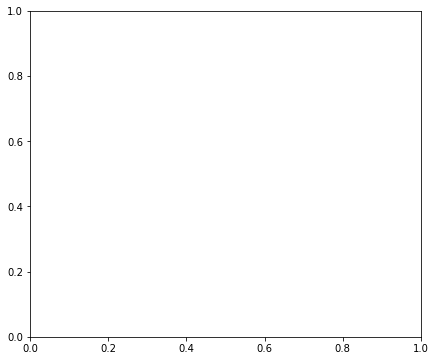

In [4]:
stack = stackstac.stack(item, assets=["red", "green", "blue",])
x_utm, y_utm = pyproj.Proj(stack.crs)(20, 5)
buffer = 500  # meters
aoi = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
data = aoi.compute()
data.plot.imshow(row="time", rgb="band", robust=True, size=6)

In [5]:
import numpy as np
from scipy import ndimage as nd

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. 
                 data value are replaced where invalid is True
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """    
    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, 
                                    return_distances=False, 
                                    return_indices=True)
    return data[tuple(ind)]

C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

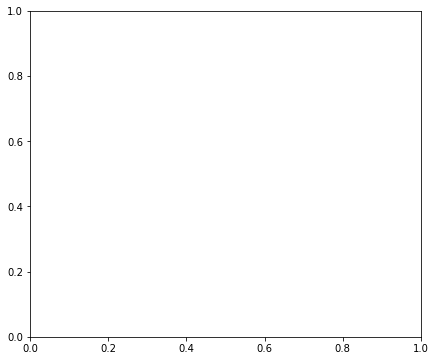

In [6]:
stack = stackstac.stack(item, assets=["red", "green", "blue",])
x_utm, y_utm = pyproj.Proj(stack.crs)(20, 5)
buffer = 500  # meters
aoi = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
data = aoi.compute()
# data = data.interpolate_na(dim='x', method = "nearest")
data.plot.imshow(row="time", rgb="band", robust=True, size=6, )
plt.axis('off')

In [83]:
data = fill(data.data)
out_image = ((data - np.nanmin(data) ) / (np.nanmax(data) - np.nanmin(data)))

(1, 3, 33, 34)

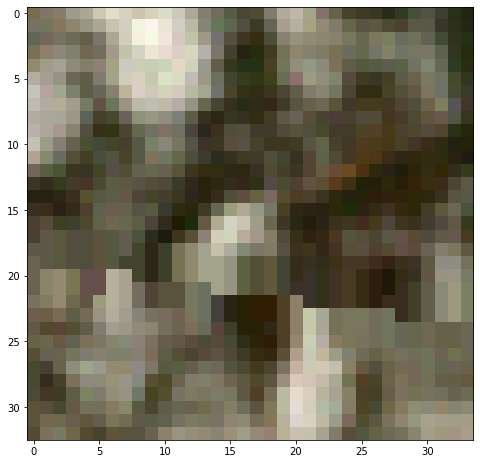

In [97]:
image = np.rollaxis(out_image.squeeze(), 0, 3)
plt.figure(figsize = (8, 8))
plt.imshow(image)
plt.show()
plt.axis('off')
plt.close()

In [69]:
im2display = data.transpose((1,2,0))
im2display

ValueError: axes don't match array

In [18]:
stack = stackstac.stack(
    items, assets=["red", "green", "blue",]).where(lambda x: x > 0, other=np.nan)
x_utm, y_utm = pyproj.Proj(stack.crs)(20, 5)
buffer = 500  # meters
data = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
data = ((data - data.min()) ) / (data.max() - data.min())
image = data.median("time", keep_attrs=True).compute()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

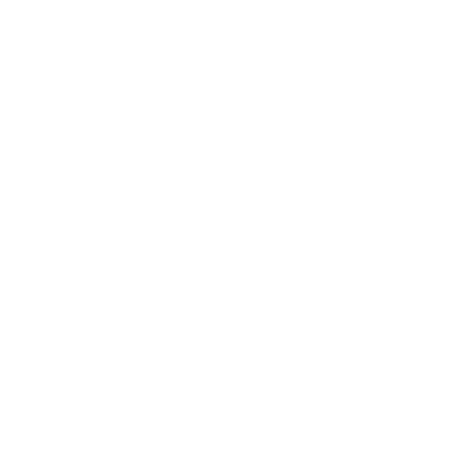

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);